In [1]:
import json
import xmltodict
import math
import skimage.io as io
import skimage as sk
import cv2 as cv
import numpy as np
from cmath import sqrt
from commonfunctions import *
from PIL import Image as im
#scale
from math import ceil
#from Rect import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

Utility functions for image preprocessing

For variance normalization
we need:
1- integral of the image
2- integral of the square of the image
3- calulate the the varia

var=mean^2 -1/N(sum(X^2))

In [2]:
#var=mean^2 -1/N(sum(X^2))
def calculateVariance(window,sqrdWindow):
    #Calculate mean value of the image and square it
    #sqrdMean=(np.mean(window))**2
    mean=((window[1][1]+window[-1][-1]-window[1][-1]-window[-1][1])/np.size(window))
    
    #Sum of pixels in integral of the squared image
    #sqrdSum=np.sum(sqrdWindow)
    sqrdSum=(sqrdWindow[1][1]+sqrdWindow[-1][-1]-sqrdWindow[1][-1]-sqrdWindow[-1][1])
    
    #Number of pixels in the window
    N=np.size(window)
    
    #Calculated variance
    variance=(sqrdSum/N)-(mean*mean)
    
    #Normalize the window and return it
    # normalizedWindow=window*variance

    return variance

In [3]:
#calculate integral of the image(to be updated for better optimization)
# def integrateImage(img,i,j,cum):
def integrateImage(img):    
   
    rows=img.shape[0]
    cols=img.shape[1]
    integralImage=np.zeros((rows+1,cols+1))
    integralImage[1:,1:]=np.cumsum(img,1)
    integralImage=np.cumsum(integralImage,0)
        
        
    # return outputImage[i][j]
    return integralImage


In [4]:

# img=np.array([[1,2,2,4,1],[3,4,1,5,2],[2,3,3,2,4],[4,1,5,4,6],[6,3,2,1,3]])
# print(img)

# integralImage=integrateImage(img)
# sqrdImage=np.square(img)
# sqrdIntegralImage=integrateImage(sqrdImage)

# variance1=calculateVariance(integralImage,sqrdIntegralImage)
# variance2=np.var(img)

# print(integralImage)

# # print(img)



In [5]:
# window=np.ones((24,24))

# normalizedImagee=varianceNormalize(window,np.square(window))

Rect class

In [6]:
#x=cols
#y=rows
class Rect:
    def __init__(self,inputText,y1=0,x1=0,width=0,height=0,weight=0.0,x2=0,y2=0):
        splitInput = inputText.split(" ")
        
        self.x1=int(splitInput[0])-1
        self.y1=int(splitInput[1])-1
        
        
        
        self.width=int(splitInput[2])
        self.height=int(splitInput[3])
     
        self.weight=float(splitInput[4])    
        
        self.y2=self.y1+self.height
        self.x2=self.x1+self.width    
 
    def calculateArea(self,window,scale):
        #self.printRect()
       # print("window values: ",window[self.y2][self.x2],window[self.y1][self.x1],window[self.y1][self.x2],window[self.y2][self.x1])
        scaledX1=self.x1*scale
        scaledY1=self.y1*scale
        scaledY2=self.y2*scale
        scaledX2=self.x2*scale
        area=(window[scaledY2][scaledX2]+window[scaledY1][scaledX1]-window[scaledY1][scaledX2]-window[scaledY2][scaledX1])
       # print("weight*area/size: ",(self.weight*area)/(np.size(window)))
        #return (self.weight*area)/((window[0][0]+window[-1][-1]-window[0][-1]-window[-1][-0]))
        return (self.weight*area)/np.size(window)
    
    def printRect(self):
        print('Rect')
        print('x1: ',self.x1)
        print('x2: ',self.x2)
        print('y1: ',self.y1)
        print('y2: ',self.y2)
        print('width: ',self.width)
        print('height: ',self.height)
        print('weight: ',self.weight)
     

In [7]:
# text='1 8 19 12 -1.'
# rectangle=Rect(text)

# img=io.imread('coffee.jpeg',as_gray=True)
# integralImage=integrateImage(img)
# window=integralImage[0:23,0:23]

# text1='6 4 12 9 -1.'
# rectangle1=Rect(text1)
# area1=rectangle1.calculateArea(window)


# text2='6 7 12 3 3.'
# rectangle2=Rect(text2)
# area2=rectangle2.calculateArea(window)

# print(area1)
# print(area2)

Feature class 

In [8]:
#A feature is equivalent to tree node
#Each node has a value(sum of the pixels inside the rectangles).
#Either a left or a right value is returned based on the comparison with the threshold.
class Feature:    
     def __init__(self,leftValue,rightValue,threshold,rects):
          self.leftValue=leftValue
          self.rightValue=rightValue
          self.threshold=threshold
          self.rects=rects
        
     
     #Calculate initial value of the feature(two or three rectangle value)
     def calculateValue(self,window,scale):
          initialValue=0
          for i in range(0,len(self.rects)):
               initialValue+=self.rects[i].calculateArea(window,scale)
          return initialValue
     
     #weak classifier
     def classify(self,window,variance,scale):
          
          value=self.calculateValue(window,scale)
          if(value>self.threshold*variance):
              # print('feature right value after weak classifier:',self.rightValue)
               return self.rightValue
          else:
              # print('feature left value after weak classifier:',self.leftValue)
               return self.leftValue
          
     def printFeature(self):
          print('Feature: ')
          print('Left value: ',self.leftValue)
          print('Right value: ',self.rightValue)
          print('Threshold: ',self.threshold)
          for i in range(0,len(self.rects)):
               self.rects[i].printRect()
                   
          
        

Stage class

In [9]:
#Stages of the cascaded classifier 
#We have 25 stages numbered from 0 to 24
class Stage:
    def __init__(self,features,threshold):
        self.features=features
        self.threshold=threshold
    
    #Validate if a window should pass a stage
    def validateWindow(self,window,variance,scale):
        sum=0
        for i in range(0,len(self.features)):
            sum+=self.features[i].classify(window,variance,scale)  
        if(sum>self.threshold):
            return True
        else:
            return False    
    
    def printStage(self):
        print('Stage threshold',self.threshold)
        for i in range (0,len(self.features)):
            self.features[i].printFeature()         

Xml to json converter

In [10]:
#Read haar cascade xml file and convert to json
def xmlToJson(xmlFile):
    with open(xmlFile) as xml_file:
     data_dict = xmltodict.parse(xml_file.read())
    json_data = json.loads(json.dumps(data_dict))
    return json_data


In [11]:
#Call xmlToJson function
json_data=xmlToJson('haarcascade_frontalface_default.xml')
textRect=json_data['opencv_storage']['haarcascade_frontalface_default']['stages']["_"][0]['trees']['_'][0]['_']['threshold']
# print(textRect)

# rect=Rect(textRect)
# print(rect.y1)

-0.0315119996666908


Reading haar cascade frontal face xml file and mapping accordingly

In [12]:
#Stages allocation

#number of stages
numberOfStages=len(json_data['opencv_storage']['haarcascade_frontalface_default']['stages']['_'])
# print(numberOfStages)

#init list of stages
stagesList=[]

#list of features per stage
featuresList=[]

#unMapped rects list
textRects=[]

#list of rects for each feature
rectsList=[]


for i in range(0,numberOfStages):
    #allocating stage threshold
    stageThreshold=float(json_data['opencv_storage']['haarcascade_frontalface_default']['stages']['_'][i]['stage_threshold'])

    #allocate mumber of features
    numberOfFeatures=len(json_data['opencv_storage']['haarcascade_frontalface_default']['stages']['_'][i]['trees']['_'])
    
    #allocate each feature
    for j in range(0,numberOfFeatures):
        #allocate the feature's left value
        leftValue=float(json_data['opencv_storage']['haarcascade_frontalface_default']['stages']['_'][i]['trees']['_'][j]['_']['left_val'])
        
        #allocate the feature's right value
        rightValue=float(json_data['opencv_storage']['haarcascade_frontalface_default']['stages']['_'][i]['trees']['_'][j]['_']['right_val'])
        
        #allocate the feature's threshold
        featureThreshold=float(json_data['opencv_storage']['haarcascade_frontalface_default']['stages']['_'][i]['trees']['_'][j]['_']['threshold'])
        
        #allocate rects as its xml format
        textRects=json_data['opencv_storage']['haarcascade_frontalface_default']['stages']['_'][i]['trees']['_'][j]['_']['feature']['rects']['_']
        
        #map rects' xml format to Rect class's format
        for k in range(0,len(textRects)):
            rectsList.append(Rect(textRects[k]))
       

        #add each feature to features list in the stage
        featuresList.append(Feature(leftValue,rightValue,featureThreshold,rectsList))   
        
        #clear list of rects for each feature
        rectsList=[] 
        
    #append stage to the cascade stages list
    stagesList.append(Stage(featuresList,stageThreshold))
    
    #clear list of features per stage
    featuresList=[]
    




25


Cascaded classifier

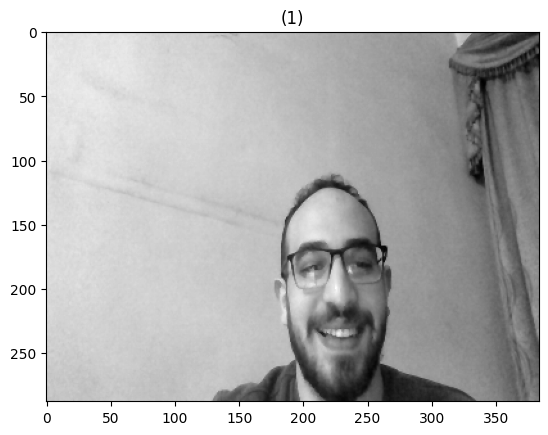

scale 1
scale 2
scale 3
scale 4


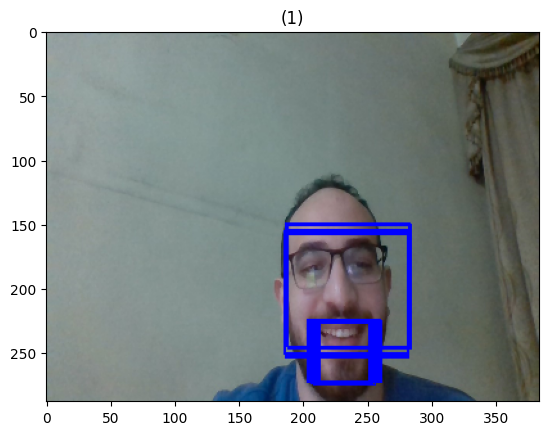

In [13]:



scale=1

#input image
finalImage=io.imread('images\images\WIN_20221231_22_23_57_Pro.jpg',as_gray=False)
finalImage = cv.resize(finalImage, (384, 288))
img=io.imread('images\images\WIN_20221231_22_23_57_Pro.jpg',as_gray=True)
img = cv.resize(img, (384, 288))
show_images([img])

for l in range(0,4):   


    # print('scale',scale)
    

    #calculate integral img  
    integralImage=integrateImage(img)


    #calculate integral of the img squared
    sqrdIntegralImage=integrateImage(np.square(img))


    #width and height of the sliding window(24x24)
    windowWidth=int(np.ceil(24*scale))
    windowHeight=int(np.ceil(24*scale))


    #windows inits
    currentWindow=np.zeros((windowHeight,windowWidth))
    currentWindowSqrd=np.zeros((windowHeight,windowWidth))
    varNormalizedWindow=np.zeros((windowHeight,windowWidth))

    #boolean to check if a window passes the stage

    #list of passed windows
    passedWindowsList=[]
    rectangleIndicesList=[]

    #window score variable
    score=0


    #Main loop(sliding window and detection)
    for i in range(1,integralImage.shape[0]-windowHeight+1):
        for j in range(1,integralImage.shape[1]-windowWidth+1):
            #current window of the .integral image
            currentWindow=integralImage[i-1:i+windowHeight,j-1:j+windowWidth] 

            #current window of integral image squared 
            currentWindowSqrd=sqrdIntegralImage[i-1:i+windowHeight,j-1:j+windowWidth]
            #variance normalization of the image
            #varNormalizedWindow=varianceNormalize(currentWindow,currentWindowSqrd)
            variance=calculateVariance(currentWindow,currentWindowSqrd)


        #Loop on the cascaded classifiers
            for k in range(0,len(stagesList)):
            #return a boolean based on the window's validation with a stage
                passed=stagesList[k].validateWindow(currentWindow,np.sqrt(variance),scale)

            #stagesList[k].printStage()
                if(not passed):
                    break
                else:
                    score+=1
                
            #print(score)
            if(score==25):
                # passedWindowsList.append(img[i:i+windowHeight,j:j+windowWidth])
                finalImage=cv.rectangle(finalImage,(j,i),(j+windowWidth,i+windowHeight),(0,0,255),1)
            score=0

    
    # show_images([finalImage])
    scale=int(np.ceil(scale*(1.25)))
    
show_images([finalImage])